In [73]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image, ImageEnhance
import gcsfs
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
def load_model_from_gcs(bucket_name, model_path):
    fs = gcsfs.GCSFileSystem(project = 'long-sonar-426316-c7')
    full_model_path = f'{bucket_name}/{model_path}'
    with fs.open(full_model_path, 'rb') as f:
        model = torch.load(f)

    return model

In [47]:
trained_deeplab = load_model_from_gcs("truss-image-seg", "model/trained_deeplab_resnet101.pt")

In [48]:
trained_deeplab

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [128]:
def sliding_window(image, step_size, window_size):
    # Slide a window across the image
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [129]:
def pad_image(image, window_size):
    # Pad the image to make sure dimensions are multiples of window_size
    pad_height = (window_size[0] - image.shape[0] % window_size[0]) % window_size[0]
    pad_width = (window_size[1] - image.shape[1] % window_size[1]) % window_size[1]
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
    return padded_image

In [216]:
def segment_image(model, image_path, window_size=(512, 512), step_size = 256):
    model.eval()
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    image_np = pad_image(image_np, window_size)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.4843, 0.3917, 0.3575], std = [0.2620, 0.2456, 0.2405])
    ])
    
    # Initialize the segmented image
    segmented_image = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
    
    # Process patches
    for (x, y, patch) in sliding_window(image_np, step_size, window_size):
        patch = transform(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(patch)['out'].cpu().numpy()
            # output = torch.sigmoid(output).squeeze().cpu().numpy()
        segmented_image[y:y + window_size[1], x:x + window_size[0]] = output
    
    return segmented_image[:image.size[1], :image.size[0]]

In [161]:
def overlay_mask_onto_image(mask, image_path):
    image = Image.open(image_path).convert("RGB")
    mask_rgb = np.zeros_like(np.array(image))
    mask_rgb[:, :, 0] = (mask * 255)
    
    mask_pil = Image.fromarray(mask_rgb)
    mask_pil = ImageEnhance.Brightness(mask_pil).enhance(1)
    overlay = Image.blend(image, mask_pil, alpha = 0.5)
    return overlay

In [212]:
image_path = "fusc_0995.png"

In [213]:
output_img = segment_image(trained_deeplab, image_path, window_size = (512, 512), step_size = 256)

In [214]:
output_img.shape

(512, 512)

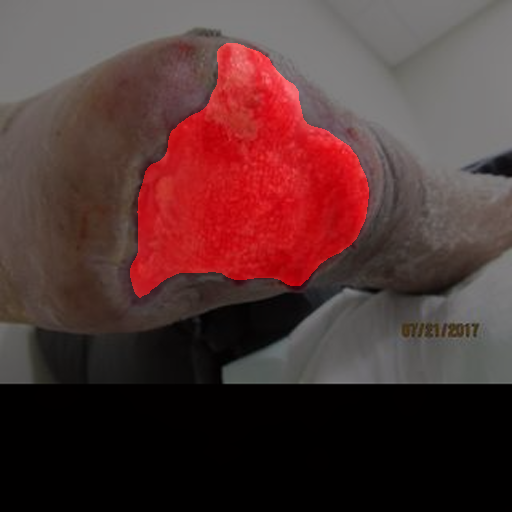

In [215]:
overlay_mask_onto_image(output_img, image_path)